# Llama 3 on Groq + E2B Code interpreter        
**Powered by open-source [Code Interpreter SDK](https://github.com/e2b-dev/code-interpreter) by [E2B](https://e2b.dev/docs)**

E2B's code interpreter SDK quickly creates a secure cloud sandbox powered by [Firecracker](https://github.com/firecracker-microvm/firecracker).

Inside this sandbox is a running Jupyter server that the LLM can use.

In [1]:
%pip install groq e2b_code_interpreter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.0 MB/s eta 0:00:00


In [3]:
# TODO: Get your Groq AI API key from https://console.groq.com/
GROQ_API_KEY = ""

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = ""

# Or use 8b version
# MODEL_NAME = "llama3-8b-8192"
MODEL_NAME = "llama3-70b-8192"

SYSTEM_PROMPT = """you are a python data scientist. you are given tasks to complete and you run python code to solve them.
  - DO NOT RESPOND WITH ANYTHING ELSE BUT PYTHON CODE
  - DO NOT FORGET ANY IMPORTS LIKE `import numpy as np`
  - the python code runs in jupyter notebook.
  - every time you generate code, it's executed in a separate cell in jupyter notebook.
  - display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
  - you have access to the internet and can make api requests.
  - you also have access to the filesystem and can read/write files.
  - you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
  - you can run any python code you want, everything is running in a secure sandbox environment."""

In [6]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.notebook.exec_cell(
    code,
    on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
    on_stdout=lambda stdout: print("[Code Interpreter]", stdout),
    # You can also stream code execution results
    # on_result=...
  )

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

In [8]:
import os
import json
import re
from groq import Groq

client = Groq(api_key=GROQ_API_KEY)

def match_code_blocks(text):
    pattern = re.compile(r'```(?:python)?[\n\r](.*?)```', re.DOTALL)
    return pattern.findall(text)

def chat_with_llama(e2b_code_interpreter, user_message):
  print(f"\n{'='*50}\nUser message: {user_message}\n{'='*50}")

  messages = [
      {"role": "system", "content": SYSTEM_PROMPT},
      {"role": "user", "content": user_message}
  ]

  response = client.chat.completions.create(
      model=MODEL_NAME,
      messages=messages,
  )

  content = response.choices[0].message.content
  # print(f"\nLlama 3 Response:\n{content}")
  # print("===")

  code_results = []
  code_blocks = match_code_blocks(content)
  for code in code_blocks:
    print(f"Code to run: {code}")

    code_interpreter_results = code_interpret(e2b_code_interpreter, code)
    print(f"Tool Result: {code_interpreter_results}")
    code_results.append(code_interpreter_results)

  return code_results




User message: Visualize a distribution of haight of men based on the latest data you know
Code to run: import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# According to the World Health Organization (WHO), the average height for an adult male is approximately 172 cm (5 ft 8 in) with a standard deviation of around 8-10 cm.

# Let's simulate a distribution of heights with a mean of 172 cm and a standard deviation of 9 cm
heights = np.random.normal(loc=172, scale=9, size=10000)

# Visualize the distribution
plt.hist(heights, bins=30, density=True, alpha=0.6, color='g')

# Plot a fitted normal distribution curve
x = np.linspace(150, 200, 100)
y = stats.norm.pdf(x, loc=172, scale=9)
plt.plot(x, y, 'r--')

plt.xlabel('Height (cm)')
plt.ylabel('Probability Density')
plt.title('Distribution of Heights of Men')
plt.show()

Running code interpreter...
Tool Result: [<e2b_code_interpreter.models.Result object at 0x7a0a3c156fe0>]
<Figure size 640x480 with 1 Axes>


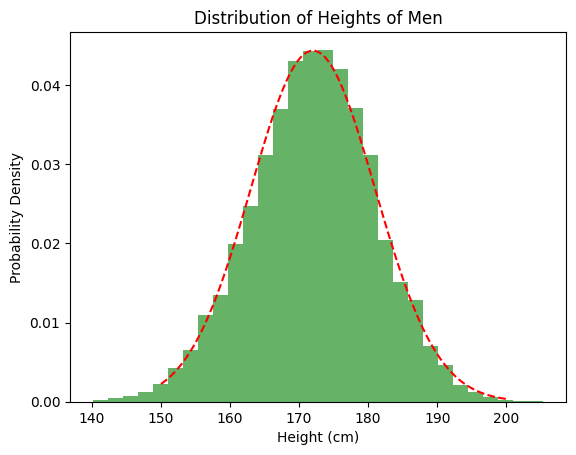

In [11]:
from e2b_code_interpreter import CodeInterpreter

with CodeInterpreter(api_key=E2B_API_KEY) as code_interpreter:
  all_code_blocks_results = chat_with_llama(
    code_interpreter,
    "Visualize a distribution of haight of men based on the latest data you know"
  )
  for result in all_code_blocks_results:
    print(result[0])

# Each code block can have multiple code interpreter results
first_result = all_code_blocks_results[0][0]

# This will render the image
# You can also access the data directly
# first_result.png
# first_result.jpg
# first_result.pdf
# ...
first_result